In [38]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import fashion_mnist
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import keras
from keras import layers, models

In [39]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [40]:
x_train = x_train.reshape(-1, 28, 28, 1) / 255
x_test = x_test.reshape(-1, 28, 28, 1) / 255

(x_train.shape, y_train.shape), (x_test.shape, y_test.shape)

(((60000, 28, 28, 1), (60000,)), ((10000, 28, 28, 1), (10000,)))

In [41]:
def create_block(input_data, filters, stride=1):
    x = layers.Conv2D(filters, kernel_size=(1,1), strides=(stride,stride), padding='valid')(input_data)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(4*filters, kernel_size=(1,1), strides=(1,1), padding='valid')(x)
    x = layers.BatchNormalization()(x)

    if stride != 1 or input_data.shape[-1] != 4*filters:
        input_data = layers.Conv2D(4*filters, kernel_size=(1,1), strides=(stride,stride), padding='valid')(input_data)
        input_data = layers.BatchNormalization()(input_data)

    x = layers.add([input_data, x])
    x = layers.Activation('relu')(x)

    return x


def resnet50(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape, name='input')
    x = layers.Conv2D(64, kernel_size=(7,7), strides=(2,2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)

    x = create_block(x, filters=64, stride=1)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='output')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='ResNet50')

    return model

In [42]:
model = resnet50(input_shape=(28,28,1),num_classes=10)
model.summary()
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(x_train, y_train, batch_size=256, epochs=30, validation_data=(x_test, y_test), shuffle=True)
scores = model.evaluate(x_test, y_test

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 14, 14, 64)   3200        ['input[0][0]']                  
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 14, 14, 64)  256         ['conv2d_4[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_147 (Activation)    (None, 14, 14, 64)   0           ['batch_normalization_4[0]

[0.37259596586227417, 0.8912000060081482]

In [43]:
train_groups = [x_train[np.where(y_train == i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test == i)[0]] for i in np.unique(y_train)]

train groups: [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
test groups: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [44]:
def gen_random_batch(in_groups, batch_halfsize=8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size=batch_halfsize)
        out_img_a += [
            in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))]
            for c_idx in group_idx
        ]
        if match_group:
            b_group_idx = group_idx
            out_score += [1] * batch_halfsize
        else:
            non_group_idx = [
                np.random.choice([i for i in all_groups if i != c_idx])
                for c_idx in group_idx
            ]
            b_group_idx = non_group_idx
            out_score += [0] * batch_halfsize
        out_img_b += [
            in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))]
            for c_idx in b_group_idx
        ]
    return np.stack(out_img_a, 0), np.stack(out_img_b, 0), np.stack(out_score, 0)

In [45]:
new_model = keras.Model(inputs=model.input, outputs=model.layers[-2].output, name='FeatureExtractor')
new_model.summary()

Model: "FeatureExtractor"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 14, 14, 64)   3200        ['input[0][0]']                  
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 14, 14, 64)  256         ['conv2d_4[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_147 (Activation)    (None, 14, 14, 64)   0           ['batch_normalizat

In [46]:
img_a_in = layers.Input(shape=x_train.shape[1:], name="ImageA_Input")
img_b_in = layers.Input(shape=x_train.shape[1:], name="ImageB_Input")
img_a_feat = new_model(img_a_in)
img_b_feat = new_model(img_b_in)
combined_features = layers.concatenate([img_a_feat, img_b_feat], name="merge_features")
combined_features = layers.Dense(256, activation="linear")(combined_features)
combined_features = layers.BatchNormalization()(combined_features)
combined_features = layers.Activation("relu")(combined_features)
combined_features = layers.Dense(128, activation="linear")(combined_features)
combined_features = layers.BatchNormalization()(combined_features)
combined_features = layers.Activation("relu")(combined_features)
combined_features = layers.Dense(1, activation="sigmoid")(combined_features)
similarity_model = models.Model(
    inputs=[img_a_in, img_b_in], outputs=[combined_features], name="SimilarityModel"
)
similarity_model.summary()

Model: "SimilarityModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 FeatureExtractor (Functional)  (None, 256)          80384       ['ImageA_Input[0][0]',           
                                                                  'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 512)          0           ['FeatureExtractor[

In [47]:
similarity_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["mae"])

1/1 [==============================] - 1s 608ms/step


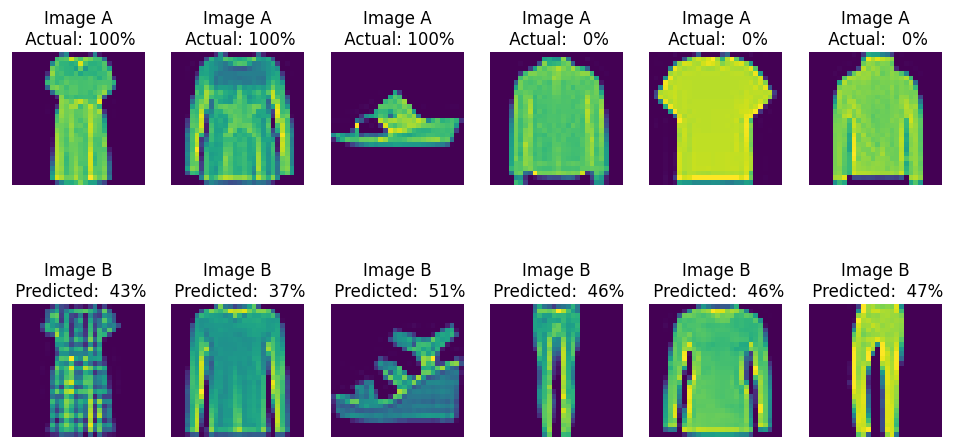

In [48]:
def show_output(nb_examples=3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = similarity_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize=(12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:, :, 0])
        ax2.imshow(c_b[:, :, 0])
    return fig


_ = show_model_output()

In [49]:
def siam_gen(in_groups, batch_size=32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size // 2)
        yield [pv_a, pv_b], pv_sim

valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit_generator(
    siam_gen(train_groups),
    steps_per_epoch=500,
    validation_data=([valid_a, valid_b], valid_sim),
    epochs=10,
    verbose=True,
)

Epoch 1/10


C:\Users\Admin\AppData\Local\Temp\ipykernel_7236\3388387785.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  loss_history = similarity_model.fit_generator(


500/500 [==============================] - 72s 133ms/step - loss: 0.2474 - mae: 0.1596 - val_loss: 0.3665 - val_mae: 0.1829
Epoch 2/10
500/500 [==============================] - 66s 132ms/step - loss: 0.2001 - mae: 0.1221 - val_loss: 0.2443 - val_mae: 0.1373
Epoch 3/10
500/500 [==============================] - 66s 132ms/step - loss: 0.1841 - mae: 0.1127 - val_loss: 0.2309 - val_mae: 0.1299
Epoch 4/10
500/500 [==============================] - 65s 130ms/step - loss: 0.1757 - mae: 0.1056 - val_loss: 0.2224 - val_mae: 0.1248
Epoch 5/10
500/500 [==============================] - 66s 132ms/step - loss: 0.1640 - mae: 0.1004 - val_loss: 0.2098 - val_mae: 0.1162
Epoch 6/10
500/500 [==============================] - 66s 131ms/step - loss: 0.1652 - mae: 0.0996 - val_loss: 0.2179 - val_mae: 0.1164
Epoch 7/10
500/500 [==============================] - 65s 130ms/step - loss: 0.1641 - mae: 0.0980 - val_loss: 0.1987 - val_mae: 0.1111
Epoch 8/10
500/500 [==============================] - 65s 130ms/st

1/1 [==============================] - 0s 44ms/step


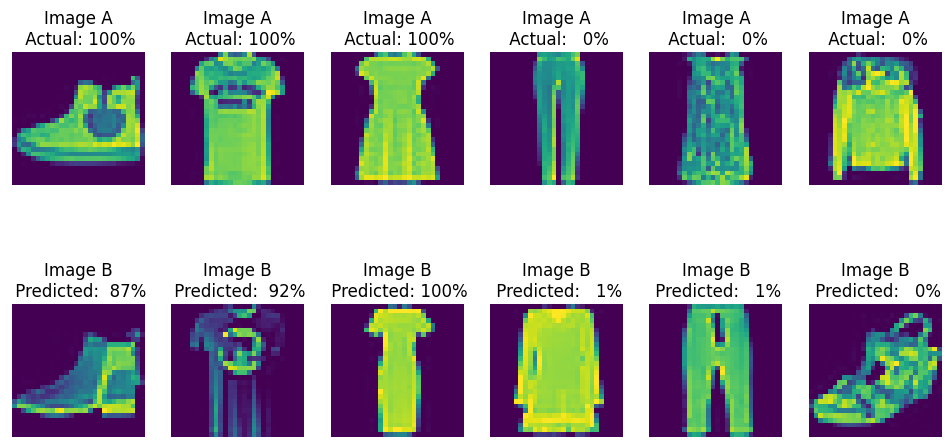

In [50]:
_ = show_model_output()

In [51]:
x_test_features = new_model.predict(x_test, verbose=True, batch_size=256)

40/40 [==============================] - 4s 84ms/step


In [52]:
%%time
from sklearn.manifold import TSNE

tsne_obj = TSNE(
    n_components=2,
    init="pca",
    random_state=101,
    method="barnes_hut",
    n_iter=500,
    verbose=2,
)
tsne_features = tsne_obj.fit_transform(x_test_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.004s...
[t-SNE] Computed neighbors for 10000 samples in 1.943s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.899806
[t-SNE] Computed conditional probabilities in 0.398s
[t-SNE] Iteration 50: error = 84.6260071, gradient norm = 0.0225756 (50 iterations in 3.735s)
[t-SNE] It

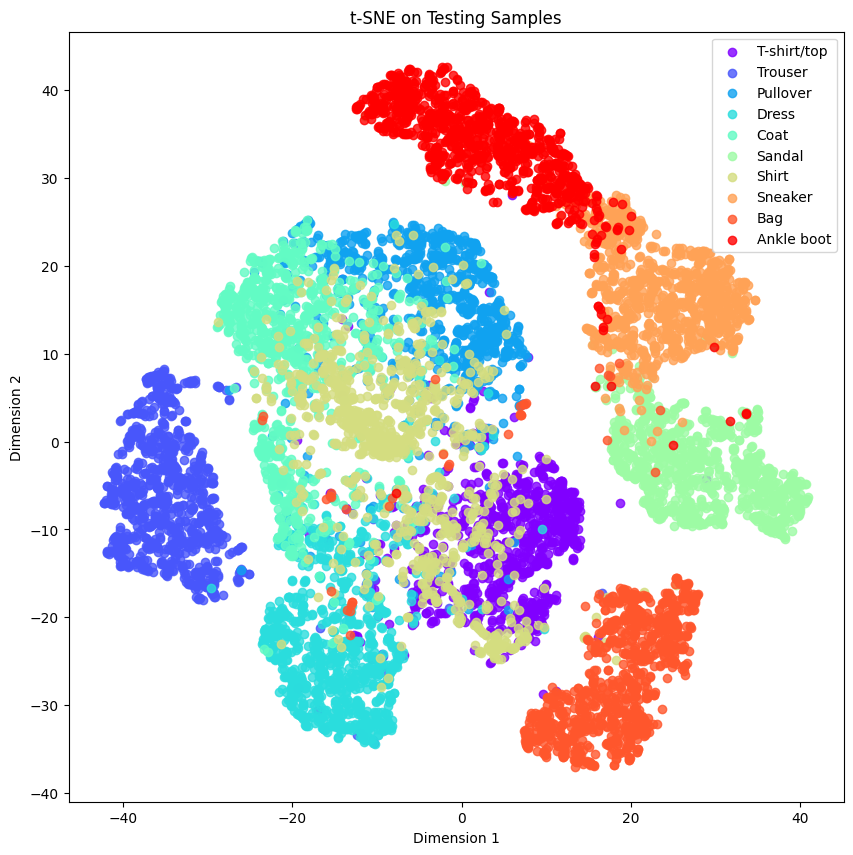

In [53]:
obj_categories = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(
        tsne_features[np.where(y_test == c_group), 0],
        tsne_features[np.where(y_test == c_group), 1],
        marker="o",
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label,
    )
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("t-SNE on Testing Samples")
plt.legend(loc="best")
plt.show(block=False)